In [1]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

CLIENT = 3

load_dotenv()

os.remove(".cache")

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=os.getenv(f"SPOTIFY_CLIENT_ID_{CLIENT}"),
        client_secret=os.getenv(f"SPOTIFY_CLIENT_SECRET_{CLIENT}")
    ),
    requests_timeout=20
)

In [2]:
# BILLBOARD_PLAYLIST_NAME_PHRASE = "Billboard Year End Hot 100"

# def get_billboard_playlists(
#     start_year: int = 2000,
#     end_year: int = 2024
# ):
#     billboard_playlists_by_id = {}

#     playlists = sp.user_playlists(
#         user="wickeddreamer96",
#         limit=100
#     )["items"]

#     for playlist in playlists:
#         phrase_idx = playlist["name"].find(BILLBOARD_PLAYLIST_NAME_PHRASE)

#         if phrase_idx != 5:
#             continue

#         playlist_year = playlist["name"][:4]

#         if not (playlist_year.isdigit() and start_year <= int(playlist_year) <= end_year):
#             continue

#         billboard_playlists_by_id[playlist["id"]] = playlist["name"]

#     return billboard_playlists_by_id

# billboard_playlists_by_id = get_billboard_playlists()
# billboard_playlists_by_id["6UeSakyzhiEt4NB3UAd6NQ"] = "2025 Billboard Year Hot 100"

# billboard_playlists_by_id

In [3]:
# import time
# import pandas as pd

# def get_artists_from_playlists(playlists_by_id: dict[str, str]):
#     artists_by_id = {}
#     limit = 100

#     for playlist_id, playlist_name in playlists_by_id.items():
#         print(f"Getting artists from {playlist_name}")

#         offset = 0

#         while True:
#             res = sp.playlist_items(
#                 playlist_id,
#                 limit=limit,
#                 offset=offset,
#                 fields="items(track(artists(id,name))),next"
#             )

#             if not res.get("items"):
#                 continue

#             for item in res.get("items"):
#                 for artist in item["track"]["artists"]:
#                     if artist["id"] not in artists_by_id:
#                         artists_by_id[artist["id"]] = artist["name"]

#             if not res.get("next"):
#                 break

#             offset += limit
#             time.sleep(0.05)

#     pd.DataFrame(
#         [(id, name) for id, name in artists_by_id.items()],
#         columns=["id", "name"]
#     ).to_csv(f"data/billboard_artists_2000_2025.tsv", sep="\t", index=False, encoding="utf-8")

#     return artists_by_id

# artists_by_id = get_artists_from_playlists(billboard_playlists_by_id)

In [4]:
import time

def get_artists_popularities_and_most_popular_song(artist_id: str):
    limit = 50

    # --- GET ARTIST'S ALBUMS ---
    print("    > Getting albums")
    offset = 0
    album_ids: set[str] = set()

    while True:
        res = sp.artist_albums(
            artist_id,
            include_groups="album,single",
            limit=limit,
            offset=offset
        )
        items = res.get("items", [])
        album_ids.update(album["id"] for album in items if album.get("id"))

        if len(items) < limit:
            break

        offset += limit
        time.sleep(0.02)

    # --- GET ARTIST'S TRACKS ---
    print(f"    > Getting tracks from {len(album_ids)} albums")
    seen_tracks: set[str] = set() # key of name + duration
    track_ids: set[str] = set()
    for album_id in album_ids:
        offset = 0

        while True:
            tracks = sp.album_tracks(album_id, limit=limit, offset=offset).get("items", [])
            for track in tracks:
                track_id = track.get("id")
                if artist_id in [track_artist["id"] for track_artist in track.get("artists", [])
                                 if track_id]:
                    key = track.get("name") + "_" + str(round(track.get("duration_ms", 0) / 1000))
                    
                    if track_id and key not in seen_tracks:
                        track_ids.add(track_id)
                        seen_tracks.add(key)

            if len(tracks) < limit:
                break
            offset += limit
            time.sleep(0.02)

    # --- GET ARTIST'S TRACKS' POPULARITIES ---
    print(f"    > Getting tracks' popularities and most popular song from {len(track_ids)} tracks")
    popular_track_name = None
    max_popularity = -1
    track_popularities = []
    track_ids = list(track_ids)

    for i in range(0, len(track_ids), limit):
        chunk = track_ids[i:min(len(track_ids), i+limit)]
        tracks = sp.tracks(chunk).get("tracks", [])

        for track in tracks:
            popularity = int(track.get("popularity", -1) or -1)
            if popularity >= 0:
                track_popularities.append(popularity)
            if popularity > max_popularity:
                popular_track_name = track["name"]
                max_popularity = popularity

        time.sleep(0.02)

    return track_popularities, popular_track_name

In [ ]:
import json

offset = 0
with open("data/popularities.ndjson", "r") as f:
    offset = sum(1 for line in f if len(line.strip()) > 0)

print(f"First {offset} artists already processed. Skipping them.")

with open("data/billboard_artists_2000_2025.tsv", "r") as f:
    n_artists = sum(1 for _ in f) - 1

with open("data/billboard_artists_2000_2025.tsv", "r") as f:
    for i, line in enumerate(f):
        if (i == 0) or (i < offset + 1):
            continue

        parts = line.strip().split("\t")
        artist_name = parts[1]
        artist_id = parts[0]

        print(f"{artist_name} ({i}/{n_artists})")
        popularities, most_popular_track = get_artists_popularities_and_most_popular_song(artist_id)

        artist_json = {
            "id": artist_id,
            "name": artist_name,
            "popularities": popularities,
            "most_popular_track": most_popular_track
        }

        with open("data/popularities.ndjson", "a") as f:
            json.dump(artist_json, f)
            f.write("\n")

First 318 artists already processed. Skipping them.
Ellie Goulding (319/1158)
    > Getting albums
    > Getting tracks from 95 albums
    > Getting tracks' popularities and most popular song from 261 tracks
Diplo (320/1158)
    > Getting albums
    > Getting tracks from 167 albums


    > Getting tracks' popularities and most popular song from 513 tracks
Calboy (321/1158)
    > Getting albums
    > Getting tracks from 56 albums
    > Getting tracks' popularities and most popular song from 121 tracks
Lauren Daigle (322/1158)
    > Getting albums
    > Getting tracks from 43 albums
    > Getting tracks' popularities and most popular song from 152 tracks
Daddy Yankee (323/1158)
    > Getting albums
    > Getting tracks from 117 albums
    > Getting tracks' popularities and most popular song from 351 tracks
Katy Perry (324/1158)
    > Getting albums
    > Getting tracks from 85 albums
    > Getting tracks' popularities and most popular song from 205 tracks
Snow (325/1158)
    > Getting albums
    > Getting tracks from 19 albums
    > Getting tracks' popularities and most popular song from 77 tracks
City Girls (326/1158)
    > Getting albums
    > Getting tracks from 29 albums
    > Getting tracks' popularities and most popular song from 81 tracks
Flipp Dinero (327/115

    > Getting tracks' popularities and most popular song from 399 tracks
A$AP Ferg (357/1158)
    > Getting albums
    > Getting tracks from 72 albums
    > Getting tracks' popularities and most popular song from 140 tracks
Jay Rock (358/1158)
    > Getting albums
    > Getting tracks from 25 albums
    > Getting tracks' popularities and most popular song from 93 tracks
James Blake (359/1158)
    > Getting albums
    > Getting tracks from 46 albums
    > Getting tracks' popularities and most popular song from 185 tracks
Nio Garcia (360/1158)
    > Getting albums
    > Getting tracks from 151 albums
    > Getting tracks' popularities and most popular song from 175 tracks
Casper Magico (361/1158)
    > Getting albums
    > Getting tracks from 122 albums


    > Getting tracks' popularities and most popular song from 136 tracks
Darell (362/1158)
    > Getting albums
    > Getting tracks from 135 albums
    > Getting tracks' popularities and most popular song from 182 tracks
Nicky Jam (363/1158)
    > Getting albums
    > Getting tracks from 135 albums


    > Getting tracks' popularities and most popular song from 240 tracks
N.E.R.D (364/1158)
    > Getting albums
    > Getting tracks from 17 albums
    > Getting tracks' popularities and most popular song from 88 tracks
Pharrell Williams (365/1158)
    > Getting albums
    > Getting tracks from 45 albums
    > Getting tracks' popularities and most popular song from 119 tracks
Logic (366/1158)
    > Getting albums
    > Getting tracks from 84 albums
    > Getting tracks' popularities and most popular song from 298 tracks
Alessia Cara (367/1158)
    > Getting albums
    > Getting tracks from 50 albums
    > Getting tracks' popularities and most popular song from 158 tracks
Justin Timberlake (368/1158)
    > Getting albums
    > Getting tracks from 49 albums
    > Getting tracks' popularities and most popular song from 195 tracks
Kenny Chesney (369/1158)
    > Getting albums
    > Getting tracks from 36 albums
    > Getting tracks' popularities and most popular song from 294 tracks
Brett

In [ ]:
import json

artists_by_name = {}

with open("data/popularities.ndjson", "r") as f:
    for line in f:
        l = line.strip()
        if len(l) == 0:
            continue
        
        artist_json = json.loads(l)
        artist_name = artist_json["name"]

        del artist_json["name"]
        del artist_json["id"]

        artists_by_name[artist_name] = artist_json

In [ ]:
import numpy as np

def one_hit_pvalue_ecdf(popularities):
    x = np.asarray(popularities, dtype=float)
    n = len(x)
    if n < 5:  # too few points -> unreliable
        return np.nan

    x_sorted = np.sort(x)
    x_max = x_sorted[-1]
    # F(x-) = P(X < x), to avoid giving probability 0 when there are ties at the max
    F_less = np.mean(x < x_max)
    # Probability at least one draw >= x_max under i.i.d. null:
    p = 1.0 - (F_less ** n)
    return p

In [ ]:
one_hit_pvalue_ecdf(popularities)

np.float64(0.6329182740756596)

<Axes: ylabel='Density'>

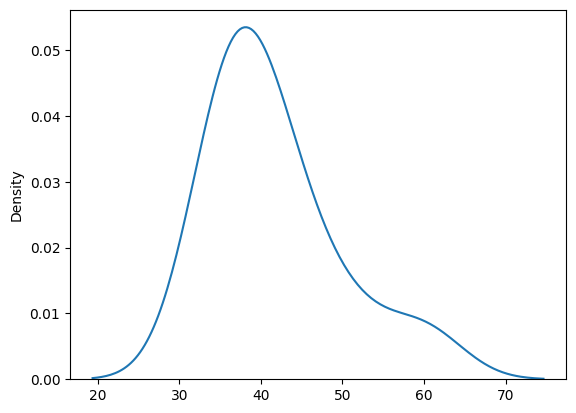

In [ ]:
sns.kdeplot(popularities)